In [1]:
# 数据是10年飞机的月流量
import torch
from torch.autograd import Variable
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms as tfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


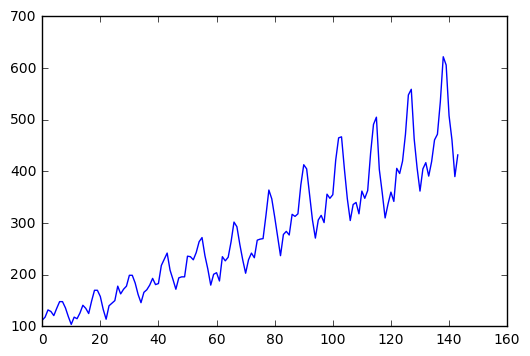

In [4]:
data_csv=pd.read_csv("./data.csv",usecols=[1])
plt.plot(data_csv)


In [5]:
# 预处理，将数据中的na 去掉，标准化到0-1 之间
data_csv=data_csv.dropna() # 去掉na
dataset=data_csv.values
dataset=dataset.astype("float32")
max_value=np.max(dataset)
min_value=np.min(dataset)
scalar=max_value-min_value
dataset=list(map(lambda x:x/scalar,dataset))


In [10]:
# 可以通过前几个月的流量来预测当月流量，可以简单的将前面几年的数据作为训练集，后面两年的数据作为测试集
def create_dataset(dataset,look_back=2):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back):
        a=dataset[i: (i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX),np.array(dataY)

In [11]:
# 创建输入输出
data_X,data_Y= create_dataset(dataset)


In [12]:
# 划分训练集和test集
train_size=int(len(data_X)*0.7)
test_size=len(data_X)-train_size
train_X=data_X[:train_size]
train_Y=data_Y[:train_size]
test_X=data_X[train_size:]
test_Y=data_Y[train_size:]

In [13]:
# 改一下形状，因为RNN 读入的数据维度是（seq，batch，feature），这里只有一个序列，因此batch 为1，输入的feature 就是希望依据的几个月份，
#这里定的是2个月，feature =2

In [14]:
train_X=train_X.reshape(-1,1,2)
train_Y=train_Y.reshape(-1,1,1)
test_X=test_X.reshape(-1,1,2)

train_x=torch.from_numpy(train_X)
train_y=torch.from_numpy(train_Y)
test_x=torch.from_numpy(test_X)


In [24]:
# 模型定义，第一部分是一个两层的RNN，每一步模型接受两个月的输入作为特征，得到一个输出结果，接受通过一个线性层将RNN的输出回归到流量的具体数值
# 这里需要用具体的view 来重新排列，因为nn.Linear 不接受三维的输入，所以要先将前两维合并在一起，然后经过线性层再将其分开，最后输出结果
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self,input_size,hidden_size,output_size=1,num_layers=2):
        super(lstm_reg,self).__init__()
        self.rnn=nn.LSTM(input_size,hidden_size,num_layers)
        self.reg=nn.Linear(hidden_size,output_size)# 回归
    def forward(self,x):
        x,_=self.rnn(x) # (seq,batch,bidden)
        s,b,h=x.shape
        x=x.view(s*b,h) # 转换成线性层的输入格式
        x=self.reg(x)
        x=x.view(s,b,-1)
        return x
    

In [25]:
net=lstm_reg(2,4)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(net.parameters(),lr=1e-2)


In [26]:
# 输入维度为2（两个月）， 隐藏层维度可以任意指定，选4


In [28]:
# 开始训练
for e in range(1000):
    var_x=Variable(train_x)
    var_y=Variable(train_y)
    # 前向传播
    out=net(var_x)
    loss=criterion(out,var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(e+1) %100 ==0: # 每100次输出结果
        print(str(e+1),loss.data)

100 tensor(0.0034)
200 tensor(0.0026)
300 tensor(0.0015)
400 tensor(0.0014)
500 tensor(0.0014)
600 tensor(0.0013)
700 tensor(0.0010)
800 tensor(0.0009)
900 tensor(0.0007)
1000 tensor(0.0007)


In [30]:
# 预测模型
net=net.eval() # 转换为测试模型
data_x=data_X.reshape(-1,1,2)
data_x=torch.from_numpy(data_x)
var_data=Variable(data_x)
pred_test=net(var_data) # 测试集的预测结果

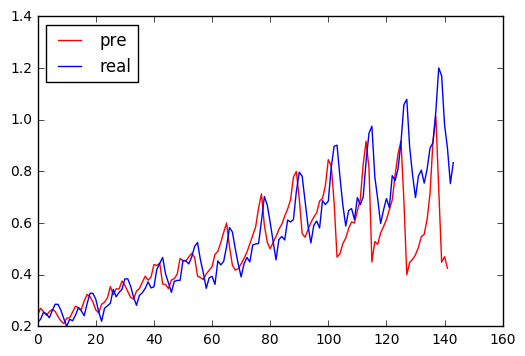

In [31]:
# 改变输出的格式
pred_test=pred_test.view(-1).data.numpy()
# 画实际结果和预测的结果
plt.plot(pred_test,"r",label="pre")
plt.plot(dataset,"b",label="real")
plt.legend(loc="best")
